# CHAPTER 20 - Learning Probabilistic Models 2

### Instructor: Brandon Haworth

#### Notebook Credit: George Tzanetakis
Jupyter Notebooks you encounter during the course were largely developed by Prof. Tzanetakis from a previous iteration of this course. I've since changed/developed them where necessary for my own iterations of CSC 421.

## WORKPLAN 

The section number is based on the 4th edition of the AIMA textbook and is the suggested
reading for this week. Each list entry provides just the additional sections. For example, the Expected reading includes the sections listed under Basic as well as the sections listed under Expected. Some additional readings are suggested for Advanced. 

1. Basic: Sections **20.1**, **20.2.1**, **20.2.2**, and **Summary**
2. Expected: Same as Basic plus **20.3**, **20.3.1**, **20.3.3**
3. Advanced: All the chapter including bibliographical and historical notes 


We have covered a variety of probabilistic models that model uncertainty and allow us to do inference in different ways. In this notebook, we describe some of the ways we can estimate probabilistic models from data. These techniques provide the connection between statistics, probability, and machine learning. 

The ideas are based on Chapter 20 of the Artificial Intelligence: A Modern Approach textbook and specifically Section 20.2 Learning from Complete Data. 

**Density estimation** refers to the task of learning the probability density function (for continuous models) or the probability distribution function (for discrete models) given some data that we assume was generated from that model. **Complete data** means that we have data for all the **variables** in our model. 

The most common type of learning is **parameter learning**, where we assume a particular structure for our model and characterize it by estimating a set of parameters. For example, we might assume a normal or Gaussian multivariate distribution and estimate the mean vector and the covariance matrix that characterizes it. As another example, we might be given the structure of a Bayesian network (in terms of parent/child conditional relationships) and learn the conditional probability tables. We will also briefly discuss the problem of learning structure as well as non-parametric density estimation, in which we don't need to make any assumptions about the model. 


# Learning with Complete Data 

## A random variable class 

Define a helper random variable class based on the scipy discrete random variable functionality, providing both numeric and symbolic RVs. You don't need to look at the implementation - the usage will be obvious through the examples below. 


In [41]:
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np 

class Random_Variable: 
    
    def __init__(self, name, values, probability_distribution): 
        self.name = name 
        self.values = values 
        self.probability_distribution = probability_distribution 
        if all(type(item) is np.int64 for item in self.values): 
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, 
                        values = (values, probability_distribution))
        elif all(type(item) is str for item in values): 
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, 
                        values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values 
        else: 
            self.type = 'undefined'
            
    def sample(self,size): 
        if (self.type =='numeric'): 
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'): 
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples 
        
    def prob_of_value(self, value): 
        indices = np.where(self.values == value)
        return self.probability_distribution[indices[0][0]]

            

# Bayesian Learning

The two important terms we will cover are data and hypotheses or models. The hypotheses are different probabilistic theories. Let's consider the example described in the book. 

We have a candy manufacturer that produces bags of candy wrapped in the same opaque wrapper. The flavours are cherry and lime. There are 5 kinds of bags: 

* h1: 100% cherry
* h2: 75% cherry and 25% lime 
* h3: 50% cherry and 50% lime 
* h4: 25% cherry and 75% lime 
* h5: 100% lime 

Given a new bag of candy, the random variable *H* takes one of these 5 values: h1, h2, h3, h4, h5. We don't know which type it is and we gradually unwrap candy D1, D2, D3,..., DN, where each of those is a random variable with value $cherry$ and $lime$ (the bags are really bi,g so replacement does not make a difference). 

The task is given a sequence of observations D1, ... DN to predict the flavour of the next piece of candy. 
As an extreme example, if we observe a sequence of 100 lime candies, then we have high confidence that the bag is of type h5 and therefore the next candy will be lime. 

One approach to solving this type of problem is the maximum likelihood described previously. This consists of selecting the "best" hypothesis using the maximum likelihood and then making the prediction using that hypothesis. If each candy bag is equally likely, then this works. 



In [42]:
import collections 
data_book = ['l'] * 10
data_other = ['l','c','l','l','l','l','l','c','l','c']

counts_book = collections.Counter(data_book)
print(counts_book['c'], counts_book['l'])
counts_other = collections.Counter(data_other)
print(counts_other['c'], counts_other['l'])

0 10
3 7


In [43]:
h1 = [1.0, 0.0]   # h1: 100% cherry
h2 = [0.75, 0.25] # h2: 75% cherry and 25% lime 
h3 = [0.5, 0.5]   # h3: 50% cherry and 50% lime
h4 = [0.25, 0.75] # h4: 25% cherry and 75% lime 
h5 = [0.0, 1.0]   # h5: 100% lime 

prior = [0.1, 0.2, 0.4, 0.2, 0.1]
#prior = [0.2, 0.2, 0.2, 0.2, 0.2]


def likelihood(d, h): 
    counts = collections.Counter(d)
    return np.power(h[0], counts['c']) * np.power(h[1], counts['l'])

print('Likelihood of h1 for data_book:', likelihood(data_book, h1))
print('Likelihood of h2 for data_book:', likelihood(data_book, h2))
print('Likelihood of h3 for data_book:', likelihood(data_book, h3))
print('Likelihood of h4 for data_book:', likelihood(data_book, h4))
print('Likelihood of h5 for data_book:', likelihood(data_book, h5))

print('Likelihood of h1 for data_other:', likelihood(data_other, h1))
print('Likelihood of h2 for data_other:', likelihood(data_other, h2))
print('Likelihood of h3 for data_other:', likelihood(data_other, h3))
print('Likelihood of h4 for data_other:', likelihood(data_other, h4))
print('Likelihood of h5 for data_other:', likelihood(data_other, h5))


Likelihood of h1 for data_book: 0.0
Likelihood of h2 for data_book: 9.5367431640625e-07
Likelihood of h3 for data_book: 0.0009765625
Likelihood of h4 for data_book: 0.056313514709472656
Likelihood of h5 for data_book: 1.0
Likelihood of h1 for data_other: 0.0
Likelihood of h2 for data_other: 2.574920654296875e-05
Likelihood of h3 for data_other: 0.0009765625
Likelihood of h4 for data_other: 0.0020856857299804688
Likelihood of h5 for data_other: 0.0


Now, consider that we have a prior probability distribution for the hypotheses. For the candy bag scenario, let's say we know from the manufacturer that 10% of candy bags are h1, 20% are h2, 40% h3, 20% h4 and 10% h5. 

An alternative, more general approach, called *Bayesian Learning*, is to calculate the probability of each hypothesis given the data and then use all the hypotheses, weighted by their probabilities, rather than just selecting the "best" by maximum likelihood to perform the prediction. Notice that with this approach, we can take into account the prior probability over the hypotheses. 

Mathematically, we can calculate the probability of each hypothesis by weighting the likelihood by the prior: 

$${\bf P}(h_{i} | {\bf d} ) = \alpha {\bf P}({\bf d} | h_{i}){\bf P}(h_i) $$

Suppose we want to make a prediction about an unknown quantity X, such as predicting what the next candy will be. Then we have: 

$$ {\bf P}(X | {\bf d}) = \sum_{i} {\bf P}(X| {\bf d}, h_i){\bf P}(h_i|{\bf d}) = \sum_{i} {\bf P}(X|h_i) {\bf P}(h_i | {\bf d})$$

where we assume that predictions are weighted averages over the predictions of the individual hypotheses. The key terms are the **hypothesis** prior $P(h_i)$ and the **likelihood** of the data under each hypothesis $P({\bf d} | h_i)$. 

Assuming that the observations are i.i.d. we can calculate easily the likelihood like we did before, and the priors for the hypotheses are given: 

$$ P({\bf d} | h_i) = \prod_{j} P(d_k, h_i) $$

In [44]:
#TRY BOTH OF THESE! 
#data_book = ['l','l','l','l','c','c','c','c','c','c']
data_book = ['l','l','l','l','l','l','l','l','l','c']


import numpy as np

posterior = np.zeros(5)
posteriors = np.zeros((11, 5))
posteriors[0] = prior

for n in range(1,11): 
    for (i,h) in enumerate([h1,h2,h3,h4,h5]):
        posterior[i] = (prior[i] * likelihood(data_book[:n], h))
    posterior /= np.sum(posterior)
    posteriors[n] = posterior

    
x = np.arange(0,11)  
y1 = posteriors[:,0]
y2 = posteriors[:,1]
y3 = posteriors[:,2]
y4 = posteriors[:,3]
y5 = posteriors[:,4]

print(x)
print(y3)

[ 0  1  2  3  4  5  6  7  8  9 10]
[0.4        0.4        0.30769231 0.21052632 0.1322314  0.07804878
 0.0440468  0.0240692  0.01285076 0.00674661 0.09423024]


Let's try to create a figure similar to 20.1 from the textbook that plots the posterior probabilities as a function of the number of observations for each hypothesis. Each coloured line corresponds to one of the five hypotheses (bag types of candy). 

In [62]:


from bokeh.plotting import figure, show 
from bokeh.io import output_notebook 

output_notebook()
p = figure() 
# p.legend.title = 'Bayesian Learning'

for (y,label,color) in zip([y1,y2,y3,y4,y5], 
                     ['P(h1|d)', 'P(h2|d)','P(h3|d)', 'P(h4|d)', 'P(h5|d)'], 
                     ['red','green','blue','purple', 'orange']): 
    p.line(x, y, legend_label=label, line_width=2,color=color)
    p.circle(x,y,color = color)

p.legend.location = "top_left"

show(p)

Loading BokehJS ...

UnsetValueError: Circle(id='p1056', ...).radius doesn't have a value set

The plot above shows how the posterior probabilities of each hypothesis get updated as we receive more data. To make a prediction we consider all hypotheses and weigh them by their posterior probabilities. 

Let's first consider how to make a prediction without observing any data. Let's say we want the probability that the next candy is lime. 
If we only had one hypothesis, we could directly use the corresponding probability. For example, if we have an h3 bag, then the probability the next candy is lime is 0.5; if we have an h5 bag, the probability the next candy is lime is 1.0. 

Now, if we have multiple hypotheses and their priors, we simply weigh them by the prior. So for $h1, h2, h3, h4, h5$ and the prior 
$P(h1) = 0.1, P(h2) = 0.2, P(h3) = 0.4, P(h4) = 0.2, P(h5) = 0.1$
we would have: 
 
$ 0 * 0.1 + 0.25 * 0.2 + 0.5 * 0.4 + 0.75 * 0.2 + 0.1 * 1 = 0.5$

If we know that d1 is lime, then we use the posterior probabilities after d1 that we calculated above to weigh the probabilities. 


In [25]:
lime_probs = [h1[1], h2[1], h3[1], h4[1], h5[1]]
pd0 = posteriors[0,:]
print('Posteriors:',pd0)
print('Lime probabilities for each hypotheses:', lime_probs)
print('P(next=lime):', np.dot(pd0, lime_probs))

pd1 = posteriors[1,:]
print('Posteriors:',pd1)
print('Lime probabilities for each hypotheses:', lime_probs)
print('P(next=lime):', np.dot(pd1, lime_probs))


Posteriors: [0.1 0.2 0.4 0.2 0.1]
Lime probabilities for each hypotheses: [0.0, 0.25, 0.5, 0.75, 1.0]
P(next=lime): 0.5
Posteriors: [0.  0.1 0.4 0.3 0.2]
Lime probabilities for each hypotheses: [0.0, 0.25, 0.5, 0.75, 1.0]
P(next=lime): 0.6500000000000001


In [26]:
prob_next_lime_bayes = np.zeros(11)
lime_probs = [h1[1], h2[1], h3[1], h4[1], h5[1]] # lime priors

for n in range(0,11): 
    for (i,h) in enumerate([h1,h2,h3,h4,h5]):
        if (n == 0):
            posterior[i] = prior[i]
        else: # n > 0
            posterior[i] = (prior[i] * likelihood(data_book[:n], h))
    posterior /= np.sum(posterior)
    prob_next_lime_bayes[n] = np.dot(posterior, lime_probs)

print(prob_next_lime_bayes)

[0.5        0.65       0.73076923 0.79605263 0.84710744 0.88597561
 0.91500344 0.93648928 0.95238693 0.96420148 0.72637342]


We can plot the probability that the next candy is lime in a way similar to Figure 20.1 of the textbook. 

In [27]:
p = figure() 
p.line(x, prob_next_lime_bayes, line_width=2,color=color)
p.circle(x,prob_next_lime_bayes, color = color)

show(p)

UnsetValueError: Circle(id='p1056', ...).radius doesn't have a value set

Bayesian learning is very powerful, but can be computationally expensive as we have to consider all possible hypotheses, and this can become prohibitive in large problems. A common approximation is to make predictions based on the most probable hypothesis. This is called the maximum a posteriori or MAP hypothesis. Typically, as we get more data, the probability of competing hypotheses vanishes and therefor, with enough data, the MAP estimate tends to be the same as the Bayesian one.

So, in practical terms, instead of taking a sum, we take a maximum. Let's modify the code for plotting the prediction to follow this approach.

In [28]:
prob_next_lime_map = np.zeros(11)
lime_probs = [h1[1], h2[1], h3[1], h4[1], h5[1]]
for n in range(0,11): 
    for (i,h) in enumerate([h1,h2,h3,h4,h5]):
        if (n == 0):
            posterior[i] = prior[i]
        else: # n > 0
            posterior[i] = (prior[i] * likelihood(data_book[:n], h))
        
    posterior /= np.sum(posterior)
    # this is the previous weighted sum 
    #prob_next_lime[n] = np.dot(posterior, lime_probs)
    
    # instead we find the maximum posterior hypothesis and predict based on it 
    max_i = np.argmax(posterior)
    prob_next_lime_map[n] = lime_probs[max_i]
print(prob_next_lime_map)

[0.5  0.5  0.75 1.   1.   1.   1.   1.   1.   1.   0.75]


In [29]:
p = figure() 
p.line(x, prob_next_lime_bayes, line_width=2,color='blue', legend_label='Bayes')
p.circle(x,prob_next_lime_bayes, color = 'blue', legend_label='Bayes')
p.line(x, prob_next_lime_map, line_width=2,color='red', legend_label='MAP')
p.circle(x,prob_next_lime_map, color = 'red', legend_label='MAP')
p.legend.location = "top_left"
show(p)

UnsetValueError: Circle(id='p1056', ...).radius doesn't have a value set

Notice that in the case of a uniform hypothesis prior, the MAP learning reduces to choosing the hypothesis that maximizes the likelihood. So, to summarize, we have three large families/types of statistical learning: 

1. **Bayesian Learning** is the most powerful and flexible case in which all hypotheses are considered weighted by their probabilities 

2. **Maximum a Posteriori (MAP)** learning is a common approximation that only considers the most probable hypothesis. It tends to be easier to compute than BL as it does not require a big summation or integration over the possible hypotheses. 

3. **Maximum Likelihood (ML)** learning assumes that there is a uniform prior among the hypotheses. This is the simplest approach. 

With enough data, they all converge. 

**Note 1:** In machine learning, each particular model/classifier can be considered a hypothesis. Overfitting can occur when the hypothesis space is very expressive and can capture a lot of variation in the data due to noise. 
Bayesian and MAP learning methods use the prior to penalize complexity. That way, one can control the tradeoff between the complexity of a hypothesis and its degree of fit to the data. 


**Note 2:** As I have mentioned before, a lot of probability calculations are basically combinations of sums and products, and the Bayesian learning computations above are no exception. In MAP learning, instead of doing a weighted summation (dot-product) of the probabilities for different hypotheses, we select the max. A similar differentiation can be observed in Hidden Markov Models when considering the difference between maximum likelihood estimation and filtering. In a filtering operation, we are interested in knowing the current hidden state 
given a sequence of observations. In maximum likelihood state estimation, we are interested in knowing the entire sequence of hidden states that is most likely given a sequence of data. One question to ask is whether the result of filtering for a particular state would always be the same as the corresponding state in the maximum likelihood sequence of states. The answer is no. 

To understand this consider what is called a trellis diagram that shows the transitions between states in an HMM. 
To make it concrete, let's say that the states are sunny and cloudy, and we are interested in whether the state at step 3 is S1 (sunny). Multiple paths through the trellis would result in that outcome. For example 

1. sunny, sunny, sunny 
2. sunny, cloudy, sunny 
3. could, sunny, sunny 
4. cloudy, cloudy, sunny 

For filtering, we would calculate the probabilities of each of these paths by taking into account both the transition and observation model, and then we would sum them all up. So in this case, all paths are considered. 
If you view each path as a hypothesis, then this can be viewed as a type of Bayesian Learning. 

In contrast, in maximum likelihood state estimation, we compute the probability of each path as before but now at the end, we select the path that is most probable. That gives us a single path and associated probability, so the summation we used in filtering becomes a max operator. This corresponds to MAP learning. 
    

<img src="images/trellis.png" width="50%"/>


# Learning from incomplete data  


There are many scenarios in learning probabilistic models in which there are hidden variables. This means that we have data for the evidence variables, and we are interested in doing inference for some query variables, but we do **NOT** have data for the hidden variables. 

There are many scenarios where this is the case. For example, the book describes: 

1. Unsupervised clustering with mixtures of Gaussians
2. Learning Bayesian networks with hidden variables 
3. Learning HMMs from observations without associated states 

In all these cases, a common approach is to use the Expectation-Maximization (EM) algorithm. 

This is an iterative algorithm in which, at each step, we improve our estimation of the parameters of a probabilistic model. The basic idea is simple to describe. Our probabilistic model is characterized by several parameters that we will denote as $\theta$. For example for a discrete Naive Bayes classifier, this would be the probabilities of each feature given the class, for a continuous Naive Bayes classifier, this would be the mean and variance of each feature given the class, for a Bayesian network these would be the conditional probability tables, for a HMM these would be the transition model and sensor model probabilities. 

There are two steps: 

1. In the **expectation step (E-step)**, we use the current iteration model characterized by $\theta_i$ to compute the expected values of the hidden variables for each example. In other words we use our current probability model to infer reasonable choices for the hidden variables for each example. 

2. In the **maximization step (M-step)**, we have now "complete" data in the sense that we have the data values for the non-hidden variables that we had from the beginning as well as the expected data we obtained by using our current guess of the parameters of the model. In this step, we can perform maximum-likelihood parameter estimation using complete data and obtain an updated model characterized by a new $\theta_{i+}$. 

These two steps are repeated until convergence (i.e. the parameters between iterations don't change, or more accurately change by a very small amount). 

Another way to think of it is that if we have a probabilistic model we can sample it to generate data as well as use it to fill in missing values in the data that we have. After filling in these missing values, we can learn a new model and repeat the process. In several notebooks, we have seen this approach where we use a model to generate some data and then use that data to estimate a model (typically, the estimated model is close to the original model). The EM algorithm essentially alternates between these two steps. 

Once you understand this basic principle, all sorts of variations and improvements can be used. For example, the E-step can be done with approximate rather than exact inference or the M-step can be done with non-parametric estimation. The notations for specific problems can become relatively intimidating at first glance, but if you really understand the basic principle you should be able to understand them for specific cases. 


## Unsupervised learning 

Now let's revisit the basketball height example from the Learning notebook. Suppose that we know that we have two classes and we have heights. We also know that the standard deviation for each class is 10cm. However, we are not given the labels of the heights but just a dataset of heights. 

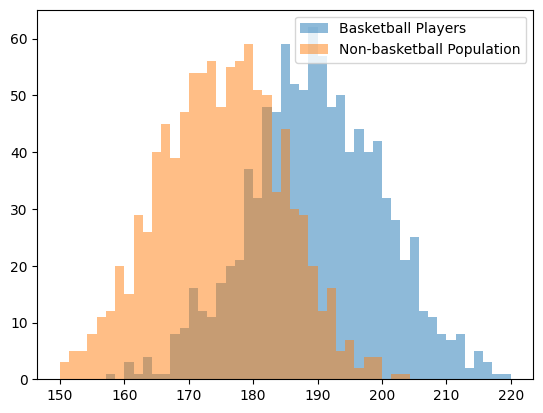

In [30]:
import numpy as np
from matplotlib import pyplot

# generate twenty samples of each class 
bball_mean_height = 190 
other_mean_height = 175 
std_height = 10
bball_samples = np.random.normal(bball_mean_height, std_height, 1000)
other_samples = np.random.normal(other_mean_height, std_height, 1000)

# Remember we can use MLE to estimate mu parameter for both groups
mu_bball = np.mean(bball_samples)
mu_other = np.mean(other_samples)

bins = np.linspace(150, 220, 50)
pyplot.hist(bball_samples, bins, alpha=0.5, label='Basketball Players')
pyplot.hist(other_samples, bins, alpha=0.5, label='Non-basketball Population')
pyplot.legend(loc='upper right')
pyplot.show()

In [31]:
heights = np.hstack([bball_samples,other_samples]) # Stack arrays in sequence horizontally (column wise).
np.random.shuffle(heights)
print(heights)

[185.91524884 180.83979646 186.80370896 ... 170.59682041 184.35556993
 168.4955964 ]


If we know the means of the two classes, we can predict the class of each instance (height)

In [32]:
from scipy.stats import norm
estimated_bball_samples = [] 
estimated_other_samples = []

for h in heights[:20]: 
    p_bball = norm(mu_bball, std_height).pdf(h)
    p_other = norm(mu_other, std_height).pdf(h)
    if (p_bball > p_other): 
        print('bball', h) 
    else: 
        print('other', h)

bball 185.9152488424637
other 180.83979646363318
bball 186.8037089616039
bball 195.7365005974056
other 177.04220450959718
other 170.40446392097093
bball 185.5519472945636
other 149.50005963203017
other 179.84980229030995
bball 182.8774465160949
other 170.18753640264123
bball 207.3071918839006
other 154.72553235830992
bball 189.90426041470107
other 172.95421674183476
other 181.60523794031647
bball 182.53529396017979
other 181.53164719469913
bball 197.66677318019043
bball 191.05731892393626


So the idea of the EM-algorithm would be let's start with a reasonable guess of the two means, then predict the heights, then re-estimate the means and keep repeating until convergence. 

In [33]:
# First, some initial guess of the parameter we do not know, mu for each class.
est_mu_bball = 200 
est_mu_other = 140 

for i in range(0,20): # iterate 20 times, remember EM is an iterative method.
    estimated_bball_samples = [] 
    estimated_other_samples = [] 
    print((i,est_mu_bball, est_mu_other))

    for h in heights:  
        # E-step - use current model to estimate values for the hidden variable (class membership)
        p_bball = norm(est_mu_bball, std_height).pdf(h)
        p_other = norm(est_mu_other, std_height).pdf(h)
        if (p_bball > p_other): 
            estimated_bball_samples.append(h)
        else: 
            estimated_other_samples.append(h)
   
    # M-step - using the estimated class values re-calculate the parameters of the model i.e the means 
    est_mu_bball = np.mean(estimated_bball_samples)
    est_mu_other = np.mean(estimated_other_samples)

print("---------Original data parameters---------")
print("NBA player mean height: ", bball_mean_height)
print("Other people mean height: ", other_mean_height)
print("Height standard deviation: ", std_height)
print("---------MLE for mu parameter---------")
print("NBA player mean height: ", mu_bball)
print("Other people mean height: ", mu_other)
print("---------EM for mu parameter---------")
print("NBA player mean height: ", est_mu_bball)
print("Other people mean height: ", est_mu_other)

(0, 200, 140)
(1, np.float64(186.1559744652531), np.float64(163.8833291107881))
(2, np.float64(188.37466810653535), np.float64(167.34778647445935))
(3, np.float64(189.7860997884321), np.float64(169.27758294008112))
(4, np.float64(190.75915448153623), np.float64(170.4773079802972))
(5, np.float64(191.38406154575117), np.float64(171.17927454299436))
(6, np.float64(191.77316957073998), np.float64(171.60064890827664))
(7, np.float64(192.08983028506384), np.float64(171.93000393326759))
(8, np.float64(192.3838556959039), np.float64(172.22057898301878))
(9, np.float64(192.5906582505335), np.float64(172.4171443346766))
(10, np.float64(192.67351969489275), np.float64(172.4957476480028))
(11, np.float64(192.73577912139004), np.float64(172.5546357652098))
(12, np.float64(192.7565789279043), np.float64(172.5742296006557))
(13, np.float64(192.7565789279043), np.float64(172.5742296006557))
(14, np.float64(192.7565789279043), np.float64(172.5742296006557))
(15, np.float64(192.7565789279043), np.float

This is a simple example of the EM algorithm with only one parameter to estimate per class to show the basic principle. In more real-world scenarios the probabilistic model can be much more complex with many parameters. 
In addition, the prediction step is typically done using likelihoods and weighted samples rather than simple 
prediction, as in this example. Therefore, the E-step and M-step tend to be more complicated and have complex update equations, but the basic principle is the same. 


**Advanced**: A great tutorial article on EM is: 

Bilmes JA. A gentle tutorial of the EM algorithm and its application to parameter estimation for Gaussian mixture and hidden Markov models. International Computer Science Institute. 1998 Apr 21;4(510):126.


http://www.leap.ee.iisc.ac.in/sriram/teaching/MLSP_18/refs/GMM_Bilmes.pdf

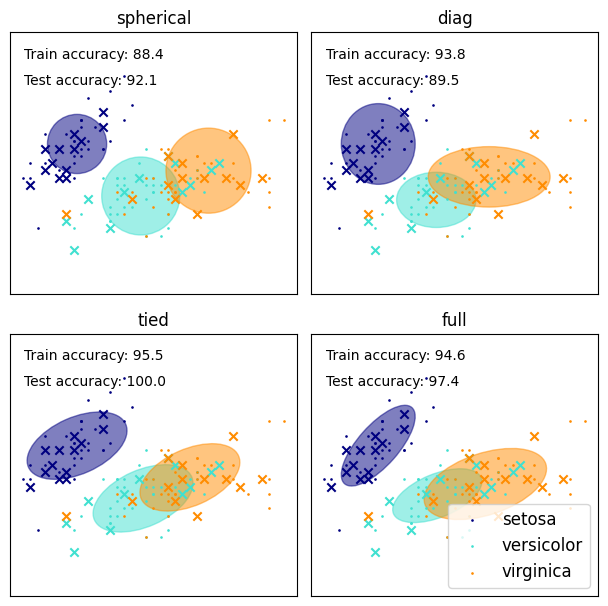

In [34]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()

In [35]:
from sklearn import datasets
digits = datasets.load_digits()
# We have 1797 instances of digits stored as 8x8=64 pixel images. These images are directly used as features. 
print(digits.data.shape)
# 
print(digits.data) 
# the 10th instance 
print(digits.data[10])

(1797, 64)
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[ 0.  0.  1.  9. 15. 11.  0.  0.  0.  0. 11. 16.  8. 14.  6.  0.  0.  2.
 16. 10.  0.  9.  9.  0.  0.  1. 16.  4.  0.  8.  8.  0.  0.  4. 16.  4.
  0.  8.  8.  0.  0.  1. 16.  5.  1. 11.  3.  0.  0.  0. 12. 12. 10. 10.
  0.  0.  0.  0.  1. 10. 13.  3.  0.  0.]


5


<Figure size 640x480 with 0 Axes>

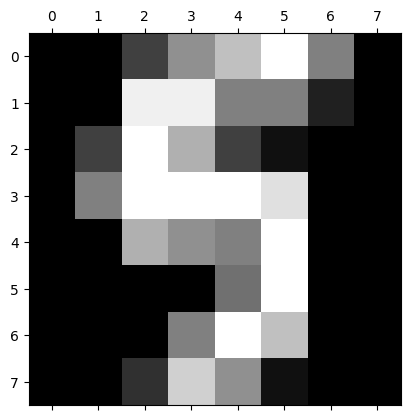

In [36]:
# we can use classifier to train a model for predicting the digit 
# of an 8 by 8 image 

from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

# as a simple example we train using all the data except the last image 
clf.fit(digits.data[:-1], digits.target[:-1]) 

# Let's see a sample image and it's target
plt.gray()
plt.matshow(digits.images[1700])
print(digits.target[1700])
plt.show()

In [37]:
# we can predict the last instance and the result is the number 8 
print(clf.predict(digits.data[-1:]))
# predict instance number gives the number 1 as the prediction 
print(clf.predict([digits.data[1]]))

[8]
[1]
